This code block has been run and the Maze class is now available for use.


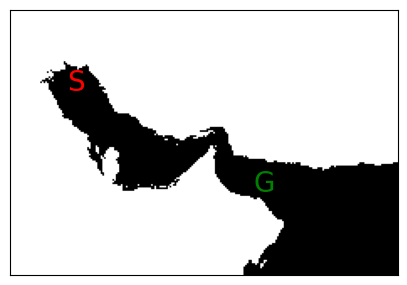

This code block has been run and the QLearningAgent class is now available for use.
The reward system has been defined.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from global_land_mask import globe
import os
from netCDF4 import Dataset
from datetime import datetime, timedelta
from itertools import product
from scipy.interpolate import interp1d
from sklearn.neighbors import KDTree
from IPython.display import clear_output
import gc

# Constants for wind and solar calculations
SOLAR_PANEL_AREA = 3000  # m^2
SOLAR_PANEL_EFFICIENCY = 0.1726
RHO_AIR = 1.225  # kg/m^3, air density at sea level
KITE_AREA = 500  # m^2
LIFT_COEFFICIENT = 1.0
DRAG_COEFFICIENT = 0.1
BASE_SHIP_SPEED = 10.29  # m/s (default speed, but will be variable)
SECONDS_IN_HOUR = 3600  # seconds

# Grid size in degrees (approximately 1 hour travel distance at ship speed)
GRID_SIZE_DEGREES = BASE_SHIP_SPEED * SECONDS_IN_HOUR / 444000  # 1 degree ~ 111 km

# Directories for wind and solar data
WIND_DATA_DIR = "mera"
SOLAR_DATA_DIR = "solar energy"

action_tuples = [(-4, 0), (4, 0), (0, -4), (0, 4), (4, 4), (4, -4), (-4, 4), (-4, -4)]
actions = {i: action for i, action in enumerate(action_tuples)}

# Load MERRA-2 wind data from a NetCDF file
def load_wind_data(date):
    filename = f"MERRA2_400.tavg1_2d_flx_Nx.{date.strftime('%Y%m%d')}.nc4.nc4"
    filepath = os.path.join(WIND_DATA_DIR, filename)
    dataset = Dataset(filepath)
    uwind = dataset.variables['ULML'][:]
    vwind = dataset.variables['VLML'][:]
    return uwind, vwind

# Load MERRA-2 solar data from a NetCDF file
def load_solar_data(date):
    filename = f"MERRA2_400.tavg1_2d_rad_Nx.{date.strftime('%Y%m%d')}.nc4_2.nc4"
    filepath = os.path.join(SOLAR_DATA_DIR, filename)
    dataset = Dataset(filepath)
    swgnt = dataset.variables['SWGNT'][:]
    return swgnt

def calculate_ship_direction(action):
    delta_y, delta_x = action
    direction = np.arctan2(delta_y, delta_x)
    return direction

# Calculate the apparent wind speed and direction
def calculate_apparent_wind(uwind, vwind, ship_speed, ship_direction):
    wind_speed = np.sqrt(uwind**2 + vwind**2)
    wind_direction = np.arctan2(vwind, uwind)
    apparent_wind_speed = np.sqrt((wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)**2 + (wind_speed * np.sin(wind_direction - ship_direction))**2)
    apparent_wind_direction = np.arctan2(wind_speed * np.sin(wind_direction - ship_direction), wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)
    return apparent_wind_speed, apparent_wind_direction

# Calculate the thrust from the kite
def calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, kite_area, lift_coefficient, drag_coefficient):
    # Calculate the angle difference between the wind direction and the ship direction
    angle_diff = np.abs(apparent_wind_direction - ship_direction)
    
    # Normalize the angle difference to be within [0, π]
    angle_diff = np.minimum(angle_diff, 2 * np.pi - angle_diff)
    
    # Calculate lift and drag forces
    lift_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * lift_coefficient
    drag_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * drag_coefficient
    
    # Determine the thrust effect based on the alignment of wind and ship direction
    thrust_effect = np.cos(angle_diff)
    thrust_effect[thrust_effect < 0] = -1
    thrust_effect[thrust_effect >= 0] = 1
    
    # Calculate effective thrust
    effective_thrust = lift_force * thrust_effect - drag_force
    return effective_thrust

# Estimate solar power output
def calculate_solar_power_output(solar_panel_area, solar_panel_efficiency, swgnt):
    power_output = solar_panel_area * solar_panel_efficiency * swgnt
    return power_output

# Calculate the power generated by the kite system
def calculate_kite_power(apparent_wind_speed, apparent_wind_direction, ship_heading, kite_area, lift_coefficient, drag_coefficient):
    # Power generated by the kite system
    lift_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * lift_coefficient
    drag_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * drag_coefficient

    # Effective thrust component
    angle_of_attack = apparent_wind_direction - ship_heading
    effective_thrust = lift_force * np.cos(angle_of_attack) - drag_force * np.sin(angle_of_attack)

    # Power output: zero if effective thrust is negative
    power_generated = np.where(effective_thrust > 0, effective_thrust * apparent_wind_speed, 0)

    return power_generated

# Calculate the Haversine distance between two points on the Earth
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

class Maze:
    def __init__(self, maze, start_position, goal_position, height, width, lat, lon):
        self.maze = maze
        self.maze_height = height
        self.maze_width = width
        self.start_position = start_position
        self.goal_position = goal_position
        self.lat = lat
        self.lon = lon

    def show_maze(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()
        np.save("maze.npy", self.maze)

print("This code block has been run and the Maze class is now available for use.")
origin = [49.469, 29.362]
destination = [58.836, 24.385]
if origin[0] > destination[0]:
    origin, destination = destination, origin

lat = np.arange(19.859, 32.995, GRID_SIZE_DEGREES)
lon = np.arange(46.248, 64.881+0.625, GRID_SIZE_DEGREES)
lon_grid, lat_grid = np.meshgrid(lon, lat)
z = globe.is_land(lat_grid, lon_grid)
z = np.array(z[::-1].astype(int))

test_lat = lat - origin[1]
test_lat = test_lat[::-1]
test_lon = lon - origin[0]
start_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
start_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
startpos = (start_pos_lon[0][0], start_pos_lat[0][0])

test_lat = lat - destination[1]
test_lat = test_lat[::-1]
test_lon = lon - destination[0]
destination_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
destination_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
destinationpos = (destination_pos_lon[0][0], destination_pos_lat[0][0])
lat = lat[::-1]
lon = lon[::-1]

maze = Maze(z, startpos, destinationpos, len(z), len(z[0]), lat, lon)
maze.show_maze()
class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.99, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, len(action_tuples)))  # Initialize Q-table with zeros
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        # Gradual decay of exploration rate
        return self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / (self.num_episodes / 2))

    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(len(action_tuples))
        else:
            return np.argmax(self.q_table[state[1], state[0]])

    def update_q_table(self, state, action, next_state, reward):
        best_next_action = np.argmax(self.q_table[next_state[1], next_state[0]])
        current_q_value = self.q_table[state[1], state[0], action]
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state[1], next_state[0], best_next_action] - current_q_value)
        self.q_table[state[1], state[0], action] = new_q_value

print("This code block has been run and the QLearningAgent class is now available for use.")
goal_reward = 1000000
wall_penalty = -200000000
energy_consumption_penalty = -100  # Penalty for energy consumption
max_steps_per_episode = 3945  # 365 days * 24 hours
print("The reward system has been defined.")

def finish_episode(agent, maze, current_episode, start_time, train=True, optimize_for="energy"):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    solar_fluxes = []
    kite_thrusts = []
    kite_powers = []

    ship_direction = np.pi / 4  # Assuming a fixed ship direction (45 degrees from North)

    time_increment = timedelta(hours=1)
    current_time = start_time

    uwind, vwind = load_wind_data(current_time)
    swgnt = load_solar_data(current_time)

    while not is_done and episode_step < max_steps_per_episode:
        action = agent.get_action(current_state, current_episode)
        
        # Debugging output to check the action
        
        if action < 0 or action >= len(actions):
            print(f"Invalid action: {action}")
            break

        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        if (0 <= next_state[0] < maze.maze_width) and (0 <= next_state[1] < maze.maze_height):
            if maze.maze[next_state[1], next_state[0]] == 1:
                reward = wall_penalty
                next_state = current_state
            elif next_state == maze.goal_position:
                path.append(next_state)
                reward = goal_reward
                is_done = True
            else:
                path.append(next_state)
                lat1, lon1 = maze.lat[current_state[1]], maze.lon[current_state[0]]
                lat2, lon2 = maze.lat[next_state[1]], maze.lon[next_state[0]]
                lat_end, lon_end = maze.lat[maze.goal_position[1]], maze.lon[maze.goal_position[0]]
                distance_reward = -0.1 * abs(haversine_distance(lat1, lon1, lat2, lon2)) - abs(haversine_distance(lat1, lon1, lat_end, lon_end))
                
                # Calculate wind and solar effects
                hour_index = current_time.hour
                apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(uwind[hour_index], vwind[hour_index], BASE_SHIP_SPEED, np.arctan2(lon2 - lon1, lat2 - lat1))
                effective_thrust = calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                solar_power_output = calculate_solar_power_output(SOLAR_PANEL_AREA, SOLAR_PANEL_EFFICIENCY, swgnt[hour_index])
                
                # Calculate wind power (assuming zero if not aligned with ship direction)
                wind_power = calculate_kite_power(apparent_wind_speed, apparent_wind_direction, ship_direction, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                
                # Calculate energy consumption
                energy_gain = (effective_thrust.mean() - wind_power.mean() + solar_power_output.mean()) * 0.01  # Adjust scaling as necessary
                energy_reward = energy_consumption_penalty * energy_gain
                
                # Combine rewards
                if optimize_for == "energy":
                    reward = distance_reward + energy_reward
                else:
                    reward = distance_reward

                # Record values for plotting later
                solar_fluxes.append(solar_power_output.mean())
                kite_thrusts.append(effective_thrust.mean())
                kite_powers.append(wind_power.mean())

                # Update time and load new data if day changes
                current_time += time_increment
                if current_time.hour == 0:
                    try:
                        uwind, vwind = load_wind_data(current_time)
                        swgnt = load_solar_data(current_time)
                    except FileNotFoundError:
                        break  # Stop if data is not available for the next day

        else:
            reward = wall_penalty
            next_state = current_state

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        current_state = next_state

    return episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers

def train_agent(agent, maze, start_time, num_episodes=100, optimize_for="energy", high_res_maze=None):
    episode_rewards = []
    episode_steps = []
    all_solar_fluxes = []
    all_kite_thrusts = []
    all_kite_powers = []
    all_rewards = []
    paths = []
    best_path = []
    best_solar_fluxes = []
    best_kite_thrusts = []
    best_kite_powers = []
    best_reward = -float('inf')

    for episode in range(num_episodes):
        episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers = finish_episode(agent, maze, episode, start_time, train=True, optimize_for=optimize_for)
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        all_solar_fluxes.append(solar_fluxes)
        all_kite_thrusts.append(kite_thrusts)
        all_kite_powers.append(kite_powers)
        all_rewards.append(episode_reward)
        paths.append(path)
        # Display progress every 100 episodes
        print(f"Episode {episode} - Steps: {episode_step}, Reward: {episode_reward}")
        if episode % 100 == 0:
            
            clear_output(wait=False)
    
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_path = path
            best_solar_fluxes = solar_fluxes
            best_kite_thrusts = kite_thrusts
            best_kite_powers = kite_powers

    # Translate the best path into latitude and longitude
    best_path_lat_lon = [(maze.lat[pos[1]], maze.lon[pos[0]]) for pos in best_path]

    # Use the provided high-resolution maze
    new_z = high_res_maze

    # Translate best_path_lat_lon into points on the new high-resolution maze
    new_lat = np.linspace(min(maze.lat), max(maze.lat), new_z.shape[0])
    new_lon = np.linspace(min(maze.lon), max(maze.lon), new_z.shape[1])
    
    new_best_path = []
    for lat, lon in best_path_lat_lon:
        # Find the closest latitude index
        lat_idx = (np.abs(new_lat - lat)).argmin()

        # Find the closest longitude index
        lon_idx = (np.abs(new_lon - lon)).argmin()

        new_best_path.append((lon_idx, lat_idx))

    # Ensure there are no duplicate points
    new_best_path = list(dict.fromkeys(new_best_path))

    # Sort the new_best_path based on x values (longitudes)
    new_best_path = sorted(new_best_path, key=lambda x: x[0])

    return episode_rewards, episode_steps, all_solar_fluxes, all_kite_thrusts, all_kite_powers, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_reward, new_best_path, new_z


start_time = datetime(2023, 1, 1)
agent = QLearningAgent(maze, num_episodes=1000)

def finish_episode_with_average_data(agent, maze, current_episode, seasonal_data, season, train=True, optimize_for="energy"):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    solar_fluxes = []
    kite_thrusts = []
    kite_powers = []

    while not is_done and episode_step < max_steps_per_episode:
        hour_index = episode_step % 24  # Reset the hour after 24 hours

        uwind = seasonal_data[season]['uwind'][hour_index]
        vwind = seasonal_data[season]['vwind'][hour_index]
        solar = seasonal_data[season]['solar'][hour_index]

        action_index = agent.get_action(current_state, current_episode)
        action = actions[action_index]
        
        # Calculate the ship direction based on the action
        ship_direction = calculate_ship_direction(action)
        
        next_state = (current_state[0] + action[0], current_state[1] + action[1])
        
        if (0 <= next_state[0] < maze.maze_width) and (0 <= next_state[1] < maze.maze_height):
            if maze.maze[next_state[1], next_state[0]] == 1:
                reward = wall_penalty
                next_state = current_state
            elif next_state == maze.goal_position:
                path.append(next_state)
                reward = goal_reward
                is_done = True
            else:
                path.append(next_state)
                lat1, lon1 = maze.lat[current_state[1]], maze.lon[current_state[0]]
                lat2, lon2 = maze.lat[next_state[1]], maze.lon[next_state[0]]
                lat_end, lon_end = maze.lat[maze.goal_position[1]], maze.lon[maze.goal_position[0]]
                distance_reward = -0.1 * abs(haversine_distance(lat1, lon1, lat2, lon2)) - abs(haversine_distance(lat1, lon1, lat_end, lon_end))
                
                # Calculate wind and solar effects
                apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(uwind, vwind, BASE_SHIP_SPEED, ship_direction)
                effective_thrust = calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                solar_power_output = calculate_solar_power_output(SOLAR_PANEL_AREA, SOLAR_PANEL_EFFICIENCY, solar)
                
                # Calculate wind power (assuming zero if not aligned with ship direction)
                wind_power = np.where(np.abs(apparent_wind_direction - ship_direction) < np.pi / 2, effective_thrust, 0)
                
                # Calculate energy consumption
                energy_gain = (effective_thrust.mean() - wind_power.mean() + solar_power_output.mean()) * 0.01  # Adjust scaling as necessary
                energy_reward = energy_consumption_penalty * energy_gain
                
                # Combine rewards
                if optimize_for == "energy":
                    reward = distance_reward + energy_reward
                else:
                    reward = distance_reward

                # Record values for plotting later
                solar_fluxes.append(solar_power_output.mean())
                kite_thrusts.append(effective_thrust.mean())
                kite_powers.append(wind_power.mean())
        else:
            reward = wall_penalty
            next_state = current_state

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action_index, next_state, reward)

        current_state = next_state

    return episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers


In [2]:
import numpy as np
import os
from datetime import datetime
from netCDF4 import Dataset

# Define paths to data directories
WIND_DATA_DIR = "mera"
SOLAR_DATA_DIR = "solar energy"

def clear_memory():
    gc.collect()

# Define seasons as ranges of months
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

# Load MERRA-2 wind data from a NetCDF file
def load_wind_data(date):
    filename = f"MERRA2_400.tavg1_2d_flx_Nx.{date.strftime('%Y%m%d')}.nc4.nc4"
    filepath = os.path.join(WIND_DATA_DIR, filename)
    dataset = Dataset(filepath)
    uwind = dataset.variables['ULML'][:]
    vwind = dataset.variables['VLML'][:]
    return uwind, vwind

# Load MERRA-2 solar data from a NetCDF file
def load_solar_data(date):
    filename = f"MERRA2_400.tavg1_2d_rad_Nx.{date.strftime('%Y%m%d')}.nc4_2.nc4"
    filepath = os.path.join(SOLAR_DATA_DIR, filename)
    dataset = Dataset(filepath)
    swgnt = dataset.variables['SWGNT'][:]
    return swgnt

# Calculate the average wind and solar data for each season, hour by hour
def calculate_hourly_averages_for_season(year):
    seasonal_data = {}
    
    for season, months in seasons.items():
        wind_u_hourly_total = np.zeros((24,) + load_wind_data(datetime(year, months[0], 1))[0].shape)
        wind_v_hourly_total = np.zeros_like(wind_u_hourly_total)
        solar_hourly_total = np.zeros((24,) + load_solar_data(datetime(year, months[0], 1)).shape)
        hour_count = np.zeros(24)  # Counter for averaging

        for month in months:
            num_days = (datetime(year, month % 12 + 1, 1) - datetime(year, month, 1)).days
            for day in range(1, num_days + 1):
                date = datetime(year, month, day)
                try:
                    uwind, vwind = load_wind_data(date)
                    swgnt = load_solar_data(date)
                    
                    for hour in range(24):
                        wind_u_hourly_total[hour] += uwind[hour]
                        wind_v_hourly_total[hour] += vwind[hour]
                        solar_hourly_total[hour] += swgnt[hour]
                        hour_count[hour] += 1
                except FileNotFoundError:
                    continue

        # Calculate hourly averages
        seasonal_data[season] = {
            'uwind': wind_u_hourly_total / hour_count[:, None, None],
            'vwind': wind_v_hourly_total / hour_count[:, None, None],
            'solar': solar_hourly_total / hour_count[:, None, None]
        }
    
    return seasonal_data

# finish function
def finish_episode_with_hourly_averages(agent, maze, current_episode, seasonal_data, season, train=True, optimize_for="energy"):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    solar_fluxes = []
    kite_thrusts = []
    kite_powers = []

    while not is_done and episode_step < max_steps_per_episode:
        hour_index = episode_step % 24  # Reset the hour after 24 steps/hours

        uwind = seasonal_data[season]['uwind'][hour_index]
        vwind = seasonal_data[season]['vwind'][hour_index]
        solar = seasonal_data[season]['solar'][hour_index]

        action_index = agent.get_action(current_state, current_episode)
        action = actions[action_index]

        # Calculate the ship direction based on the action
        ship_direction = calculate_ship_direction(action)

        # Initialize reward as a wall penalty (if a wall is hit)
        reward = wall_penalty
        valid_move = True

        # Check each step incrementally for all 8 possible directions
        for step in range(1, 6):  # Check increments of 1, 2, 3, 4, 5
            for action_check in action_tuples:
                potential_state = (current_state[0] + action_check[0] * step // 5, current_state[1] + action_check[1] * step // 5)
                if (0 <= potential_state[0] < maze.maze_width) and (0 <= potential_state[1] < maze.maze_height):
                    if maze.maze[potential_state[1], potential_state[0]] == 1:
                        valid_move = False
                        break
                else:
                    valid_move = False
                    break

            if not valid_move:
                reward = wall_penalty
                break
            next_state = (current_state[0] + action[0], current_state[1] + action[1])

        if valid_move:
            if next_state == maze.goal_position:
                path.append(next_state)
                reward = goal_reward
                is_done = True
            else:
                path.append(next_state)
                lat1, lon1 = maze.lat[current_state[1]], maze.lon[current_state[0]]
                lat2, lon2 = maze.lat[next_state[1]], maze.lon[next_state[0]]
                lat_end, lon_end = maze.lat[maze.goal_position[1]], maze.lon[maze.goal_position[0]]
                distance_reward = -0.1 * abs(haversine_distance(lat1, lon1, lat2, lon2)) - abs(haversine_distance(lat1, lon1, lat_end, lon_end))
                
                # Calculate wind and solar effects
                apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(uwind, vwind, BASE_SHIP_SPEED, ship_direction)
                effective_thrust = calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                solar_power_output = calculate_solar_power_output(SOLAR_PANEL_AREA, SOLAR_PANEL_EFFICIENCY, solar)
                
                # Calculate wind power (assuming zero if not aligned with ship direction)
                wind_power = np.where(np.abs(apparent_wind_direction - ship_direction) < np.pi / 2, effective_thrust, 0)
                
                # Calculate energy consumption
                energy_gain = (effective_thrust.mean() - wind_power.mean() + solar_power_output.mean()) * 0.01  # Adjust scaling as necessary
                energy_reward = energy_consumption_penalty * energy_gain
                
                # Combine rewards
                if optimize_for == "energy":
                    reward = distance_reward + energy_reward
                else:
                    reward = distance_reward

                # Record values for plotting later
                solar_fluxes.append(solar_power_output.mean())
                kite_thrusts.append(effective_thrust.mean())
                kite_powers.append(wind_power.mean())
        else:
            next_state = current_state

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action_index, next_state, reward)

        current_state = next_state

    return episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers


In [3]:
def finish_episode_dqn(agent, env, max_steps_per_episode=1000, train=True):
    state = env.reset()
    episode_reward = 0
    episode_step = 0
    done = False
    path = []

    while not done and episode_step < max_steps_per_episode:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)

        agent.store_transition(state, action, reward, next_state, done)

        if train:
            agent.train()

        state = next_state
        episode_reward += reward
        episode_step += 1
        path.append(state)

    agent.update_target_model()  # Update target network periodically

    return episode_reward, episode_step, path


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class DQN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        self.fc3 = layers.Dense(output_dim)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
    
from collections import deque
import random

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQNAgent:
    def __init__(self, input_dim, output_dim, lr=0.001, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.model = DQN(input_dim, output_dim)
        self.target_model = DQN(input_dim, output_dim)
        self.model.build(input_shape=(None, input_dim))
        self.target_model.build(input_shape=(None, input_dim))
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.memory = ReplayMemory(10000)
        self.batch_size = 64

        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.model.fc3.units)
        else:
            state = np.expand_dims(state, axis=0).astype(np.float32)
            q_values = self.model(state)
            return np.argmax(q_values[0])

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = np.array(state_batch, dtype=np.float32)
        next_state_batch = np.array(next_state_batch, dtype=np.float32)
        reward_batch = np.array(reward_batch, dtype=np.float32)
        done_batch = np.array(done_batch, dtype=np.float32)

        with tf.GradientTape() as tape:
            q_values = self.model(state_batch)
            q_values = tf.reduce_sum(q_values * tf.one_hot(action_batch, self.model.fc3.units), axis=1)
            next_q_values = self.target_model(next_state_batch)
            max_next_q_values = tf.reduce_max(next_q_values, axis=1)
            target_q_values = reward_batch + self.gamma * max_next_q_values * (1 - done_batch)
            loss = tf.keras.losses.MSE(target_q_values, q_values)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)
        self.update_target_model()


In [8]:
import gym
from gym import spaces

class ShipNavigationEnv:
    def __init__(self, maze, seasonal_data, season):
        self.maze = maze
        self.seasonal_data = seasonal_data
        self.season = season
        self.current_state = self.maze.start_position
        self.observation_space = None  # Define this based on your environment
        self.action_space = None  # Define this based on your environment

    def reset(self):
        # Reset the environment to the initial state
        self.current_state = self.maze.start_position
        
        # Define the initial observation based on the starting state
        observation = self._get_observation()
        
        return observation

    def _get_observation(self):
        # Example observation might include the current position and environmental data
        position = self.current_state
        wind = self.seasonal_data[self.season]['uwind'][0], self.seasonal_data[self.season]['vwind'][0]
        solar = self.seasonal_data[self.season]['solar'][0]
        
        # Combine all necessary data into a single observation
        observation = np.array([position[0], position[1], wind[0], wind[1], solar])
        
        return observation

    def step(self, action):
        # Implement the environment's step logic here
        pass



In [11]:
def plot_best_path_and_data(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_reward, episode_rewards, low_res_lat, low_res_lon, high_res_lat, high_res_lon, high_res_maze):
    plt.figure(figsize=(38.4, 21.6), dpi=220)  # 4K resolution: 3840x2160 pixels

    # Plot 1: Episode rewards
    plt.subplot(3, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'{season.capitalize()} - Reward per Episode')

    # Plot 2: Steps per episode (constant for best path)
    plt.subplot(3, 2, 2)
    plt.plot([len(best_path)] * len(episode_rewards))
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title(f'{season.capitalize()} - Steps per Episode')

    # Plot 3: High-resolution maze with best path
    plt.subplot(3, 2, 3)
    plt.imshow(high_res_maze, cmap='gray')

    if best_path is not None:
        # Translate low-resolution path to latitude and longitude
        translated_path = []
        for point in best_path:
            lat = low_res_lat[point[1]]
            lon = low_res_lon[point[0]]
            translated_path.append((lat, lon))
        
        # Find the closest points on the high-resolution maze
        high_res_path = []
        for lat, lon in translated_path:
            lat_diff = np.abs(high_res_lat - lat)
            lon_diff = np.abs(high_res_lon - lon)
            closest_lat_idx = np.argmin(lat_diff)
            closest_lon_idx = np.argmin(lon_diff)
            high_res_path.append((closest_lon_idx, closest_lat_idx))

        high_res_path_x, high_res_path_y = zip(*high_res_path)
        
        # Plot the translated path with a thick line
        plt.plot(high_res_path_x, high_res_path_y, color='blue', linewidth=3)  # Thicker line for path

        # Plot the start and goal positions
        start_lat = low_res_lat[maze.start_position[1]]
        start_lon = low_res_lon[maze.start_position[0]]
        start_lat_diff = np.abs(high_res_lat - start_lat)
        start_lon_diff = np.abs(high_res_lon - start_lon)
        start_closest_lat_idx = np.argmin(start_lat_diff)
        start_closest_lon_idx = np.argmin(start_lon_diff)
        plt.scatter([start_closest_lon_idx], [start_closest_lat_idx], color='red', s=100, label='Start')

        goal_lat = low_res_lat[maze.goal_position[1]]
        goal_lon = low_res_lon[maze.goal_position[0]]
        goal_lat_diff = np.abs(high_res_lat - goal_lat)
        goal_lon_diff = np.abs(high_res_lon - goal_lon)
        goal_closest_lat_idx = np.argmin(goal_lat_diff)
        goal_closest_lon_idx = np.argmin(goal_lon_diff)
        plt.scatter([goal_closest_lon_idx], [goal_closest_lat_idx], color='green', s=100, label='Goal')

        plt.xticks([]), plt.yticks([])
        plt.grid(color='black', linewidth=2)
        plt.title(f'{season.capitalize()} - Final Path Learned in High Resolution')

    # Plot 4: Solar Flux per Step
    plt.subplot(3, 2, 4)
    plt.plot(best_solar_fluxes, label='Solar Flux (W/m^2)')
    plt.xlabel('Step')
    plt.ylabel('Solar Flux (W/m^2)')
    plt.title(f'{season.capitalize()} - Solar Flux per Step')
    plt.legend()

    # Plot 5: Kite Thrust per Step
    plt.subplot(3, 2, 5)
    plt.plot(best_kite_thrusts, label='Kite Thrust (N)')
    plt.xlabel('Step')
    plt.ylabel('Kite Thrust (N)')
    plt.title(f'{season.capitalize()} - Kite Thrust per Step')
    plt.legend()

    # Plot 6: Kite Power per Step
    plt.subplot(3, 2, 6)
    plt.plot(best_kite_powers, label='Kite Power (W)')
    plt.xlabel('Step')
    plt.ylabel('Kite Power (W)')
    plt.title(f'{season.capitalize()} - Kite Power per Step')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(season_dir, f'{season}_best_day_plots.png'), dpi=220)  # Save with high resolution
    plt.close()

    # Save the best path's solar flux and kite power data as npy files
    np.save(os.path.join(season_dir, f'{season}_best_solar_fluxes.npy'), best_solar_fluxes)
    np.save(os.path.join(season_dir, f'{season}_best_kite_powers.npy'), best_kite_powers)

    print(f"Best day of {season.capitalize()} has reward {best_reward} and is saved in {season_dir}")

def process_seasonal_routes_dqn(agent, env, season, num_episodes=1000):
    results_dir = "seasonal_routes"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    low_res_lat = env.maze.lat
    low_res_lon = env.maze.lon
    
    # Load the high-resolution latitude, longitude, and maze data separately
    high_res_lat = np.load('high_res_lat.npy')  # Assuming you saved it as 'high_res_lat.npy'
    high_res_lon = np.load('high_res_lon.npy')  # Assuming you saved it as 'high_res_lon.npy'
    high_res_maze = np.load('high_res_maze.npy')  # Assuming this is the maze data

    print(f"Processing {season.capitalize()}...")

    season_dir = os.path.join(results_dir, season)
    if not os.path.exists(season_dir):
        os.makedirs(season_dir)
    
    best_reward = -float('inf')
    best_path = None
    best_solar_fluxes = []
    best_kite_thrusts = []
    best_kite_powers = []
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers = finish_episode_dqn(agent, env, episode, train=True, optimize_for="energy")
        episode_rewards.append(episode_reward)
        print(f"Episode {episode} - Steps: {episode_step}, Reward: {episode_reward}")
        if episode % 100 == 0:
            clear_output(wait=False)

        if episode_reward > best_reward:
            best_reward = episode_reward
            best_path = path
            best_solar_fluxes = solar_fluxes
            best_kite_thrusts = kite_thrusts
            best_kite_powers = kite_powers

    # Plot the best path for the season and save the data
    plot_best_path_and_data(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_reward, episode_rewards, low_res_lat, low_res_lon, high_res_lat, high_res_lon, high_res_maze)

    # Clear data from memory after processing the season
    clear_memory()

    print(f"{season.capitalize()} processing complete and results saved.")


In [10]:
high_res_maze_file = 'high_res_maze.npy'
new_z = np.load(high_res_maze_file)

# Initialize the route agent
route_agent = QLearningAgent(maze, num_episodes=1000)

# Calculate seasonal averages
seasonal_data = calculate_hourly_averages_for_season(2023)

# Process seasonal routes
high_res_lat = np.load('high_res_lat.npy')
high_res_lon = np.load('high_res_lon.npy')
high_res_maze = np.load('high_res_maze.npy')

env = ShipNavigationEnv(maze, seasonal_data, season='winter')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent = DQNAgent(input_dim, output_dim)

num_episodes = 1000
max_steps_per_episode = 1000

for episode in range(num_episodes):
    episode_reward, episode_step, path = finish_episode_dqn(agent, env, max_steps_per_episode, train=True)
    print(f"Episode {episode}: Reward = {episode_reward}, Steps = {episode_step}")


MemoryError: Unable to allocate 1.88 GiB for an array with shape (252986224,) and data type int64

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import gc

def plot_best_path_and_data(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_reward, episode_rewards, low_res_lat, low_res_lon, high_res_lat, high_res_lon, high_res_maze):
    plt.figure(figsize=(38.4, 21.6), dpi=220)  # 4K resolution: 3840x2160 pixels

    # Plot 1: Episode rewards
    plt.subplot(3, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'{season.capitalize()} - Reward per Episode')

    # Plot 2: Steps per episode (constant for best path)
    plt.subplot(3, 2, 2)
    plt.plot([len(best_path)] * len(episode_rewards))
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title(f'{season.capitalize()} - Steps per Episode')

    # Plot 3: High-resolution maze with best path
    plt.subplot(3, 2, 3)
    plt.imshow(high_res_maze, cmap='gray')

    if best_path is not None:
        # Translate low-resolution path to latitude and longitude
        translated_path = []
        for point in best_path:
            lat = low_res_lat[point[1]]
            lon = low_res_lon[point[0]]
            translated_path.append((lat, lon))
        
        # Find the closest points on the high-resolution maze
        high_res_path = []
        for lat, lon in translated_path:
            lat_diff = np.abs(high_res_lat - lat)
            lon_diff = np.abs(high_res_lon - lon)
            closest_lat_idx = np.argmin(lat_diff)
            closest_lon_idx = np.argmin(lon_diff)
            high_res_path.append((closest_lon_idx, closest_lat_idx))

        high_res_path_x, high_res_path_y = zip(*high_res_path)
        
        # Plot the translated path with a thick line
        plt.plot(high_res_path_x, high_res_path_y, color='blue', linewidth=3)  # Thicker line for path

        # Plot the start and goal positions
        start_lat = low_res_lat[maze.start_position[1]]
        start_lon = low_res_lon[maze.start_position[0]]
        start_lat_diff = np.abs(high_res_lat - start_lat)
        start_lon_diff = np.abs(high_res_lon - start_lon)
        start_closest_lat_idx = np.argmin(start_lat_diff)
        start_closest_lon_idx = np.argmin(start_lon_diff)
        plt.scatter([start_closest_lon_idx], [start_closest_lat_idx], color='red', s=100, label='Start')

        goal_lat = low_res_lat[maze.goal_position[1]]
        goal_lon = low_res_lon[maze.goal_position[0]]
        goal_lat_diff = np.abs(high_res_lat - goal_lat)
        goal_lon_diff = np.abs(high_res_lon - goal_lon)
        goal_closest_lat_idx = np.argmin(goal_lat_diff)
        goal_closest_lon_idx = np.argmin(goal_lon_diff)
        plt.scatter([goal_closest_lon_idx], [goal_closest_lat_idx], color='green', s=100, label='Goal')

        plt.xticks([]), plt.yticks([])
        plt.grid(color='black', linewidth=2)
        plt.title(f'{season.capitalize()} - Final Path Learned in High Resolution')

    # Plot 4: Solar Flux per Step
    plt.subplot(3, 2, 4)
    plt.plot(best_solar_fluxes, label='Solar Flux (W/m^2)')
    plt.xlabel('Step')
    plt.ylabel('Solar Flux (W/m^2)')
    plt.title(f'{season.capitalize()} - Solar Flux per Step')
    plt.legend()

    # Plot 5: Kite Thrust per Step
    plt.subplot(3, 2, 5)
    plt.plot(best_kite_thrusts, label='Kite Thrust (N)')
    plt.xlabel('Step')
    plt.ylabel('Kite Thrust (N)')
    plt.title(f'{season.capitalize()} - Kite Thrust per Step')
    plt.legend()

    # Plot 6: Kite Power per Step
    plt.subplot(3, 2, 6)
    plt.plot(best_kite_powers, label='Kite Power (W)')
    plt.xlabel('Step')
    plt.ylabel('Kite Power (W)')
    plt.title(f'{season.capitalize()} - Kite Power per Step')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(season_dir, f'{season}_best_day_plots.png'), dpi=220)  # Save with high resolution
    plt.close()

    # Save the best path's solar flux and kite power data as npy files
    np.save(os.path.join(season_dir, f'{season}_best_solar_fluxes.npy'), best_solar_fluxes)
    np.save(os.path.join(season_dir, f'{season}_best_kite_powers.npy'), best_kite_powers)

    print(f"Best day of {season.capitalize()} has reward {best_reward} and is saved in {season_dir}")

def process_seasonal_routes(agent, maze, seasonal_data, season, num_episodes=1000):
    results_dir = "seasonal_routes"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    low_res_lat = maze.lat
    low_res_lon = maze.lon
    
    # Load the high-resolution latitude, longitude, and maze data separately
    high_res_lat = np.load('high_res_lat.npy')  # Assuming you saved it as 'high_res_lat.npy'
    high_res_lon = np.load('high_res_lon.npy')  # Assuming you saved it as 'high_res_lon.npy'
    high_res_maze = np.load('high_res_maze.npy')  # Assuming this is the maze data

    print(f"Processing {season.capitalize()}...")

    season_dir = os.path.join(results_dir, season)
    if not os.path.exists(season_dir):
        os.makedirs(season_dir)
    
    best_reward = -float('inf')
    best_path = None
    best_solar_fluxes = []
    best_kite_thrusts = []
    best_kite_powers = []
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers = finish_episode_with_hourly_averages(agent, maze, episode, seasonal_data, season, train=True, optimize_for="energy")
        episode_rewards.append(episode_reward)
        print(f"Episode {episode} - Steps: {episode_step}, Reward: {episode_reward}")
        if episode % 100 == 0:
            clear_output(wait=False)

        if episode_reward > best_reward:
            best_reward = episode_reward
            best_path = path
            best_solar_fluxes = solar_fluxes
            best_kite_thrusts = kite_thrusts
            best_kite_powers = kite_powers

    # Plot the best path for the season and save the data
    plot_best_path_and_data(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_reward, episode_rewards, low_res_lat, low_res_lon, high_res_lat, high_res_lon, high_res_maze)

    # Clear data from memory after processing the season
    clear_memory()

    print(f"{season.capitalize()} processing complete and results saved.")

# Example usage:
# Load the high-resolution maze once
high_res_maze_file = 'high_res_maze.npy'
new_z = np.load(high_res_maze_file)

# Initialize the route agent
route_agent = QLearningAgent(maze, num_episodes=1000)

# Calculate seasonal averages
seasonal_data = calculate_hourly_averages_for_season(2023)

# Process seasonal routes
high_res_lat = np.load('high_res_lat.npy')
high_res_lon = np.load('high_res_lon.npy')
high_res_maze = np.load('high_res_maze.npy')

# Process the routes
# Example usage for winter
process_seasonal_routes(agent=route_agent, maze=maze, seasonal_data=seasonal_data, season='winter', num_episodes=1000)


MemoryError: Unable to allocate 1.88 GiB for an array with shape (252986224,) and data type int64